## Time-Series Decomposition (More classical approaches)

Extract the seasonal patterns from the time-series

In [171]:
from data_exploitation.exports_analytics.data.scripts import time_series_generator
from data_exploitation.exports_analytics.exploratory_data_analysis.scripts import time_granularities_analysis, time_granularities_generator
from database_settings import postgres_utilities
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from sklearn import linear_model



### Get available headings

In [172]:
# Get available headings from peru_exports_sandbox
engine = postgres_utilities.engine()
available_headings = postgres_utilities.run_query_file(engine,
                                                       './../data/queries/read_available_headings.sql')
available_headings = pd.DataFrame(available_headings)
available_headings

Connected to Formatted Zone successfully!


,heading,description
0,0712909000,Otras hortalizas y mezclas de hortalizas corta...
1,0805291000,Tangelo (Citrus reticulata x Citrus paradisis)...
2,0810400000,"Arándanos rojos, mirtilos y demas frutos del g..."
3,0713359000,"Frijoles (fréjoles, porotos, alubias, judías) ..."
4,0805502100,"Limón (limón sutil, limón común, limón criollo..."
5,0810901000,"Granadilla, maracuya (parchita) y demas frutas..."
6,0702000000,Tomates frescos o refrigerados
7,0709999000,Otras hortalizas frescas o refrigeradas
8,0801220000,Nueces del Brasil sin cáscara
9,0710400000,"Maiz dulce incluso cocidos, congelados"


### Build a time-series

In [173]:
# Choose a heading
chosen_heading = '0810400000'
# Choose the observed measure (usd_kg or net_weight)
observations = 'usd_kg'

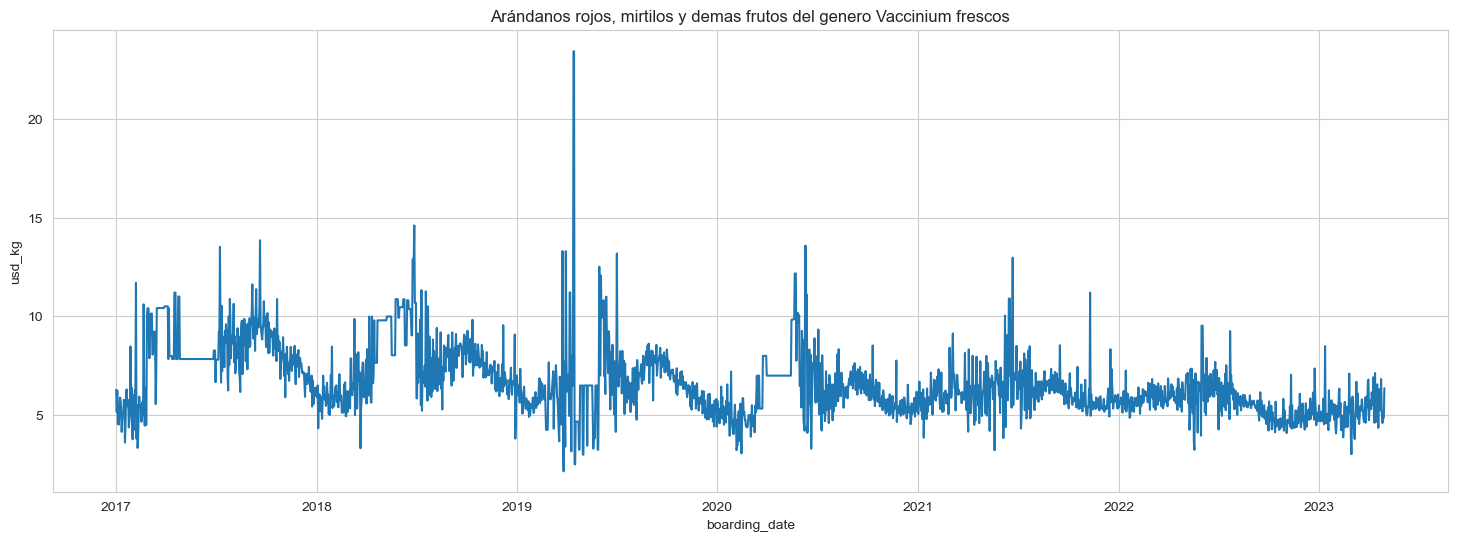

In [174]:
# Get a time-series
ts = time_series_generator.generate(chosen_heading, observations)
ts.plot()

In [175]:
# Add the time granularities
time_granularities, priority = time_granularities_generator.generate(ts.start_date, ts.end_date)
data = pd.concat([ts.data, time_granularities], axis=1)
data

,usd_kg,year,semester_in_year,quarter_in_year,month_in_year,month_in_semester,month_in_quarter,quarter_in_semester,day_in_year,day_in_semester,day_in_quarter,day_in_month,day_in_week,week_in_year,week_in_semester,week_in_quarter,week_in_month
2017-01-01,6.280,2017,1,1,1,1,1,1,1,1,1,1,7,52,26,13,5
2017-01-02,5.144,2017,1,1,1,1,1,1,2,2,2,2,1,1,1,1,1
2017-01-03,6.243,2017,1,1,1,1,1,1,3,3,3,3,2,1,1,1,1
2017-01-04,4.551,2017,1,1,1,1,1,1,4,4,4,4,3,1,1,1,1
2017-01-05,4.590,2017,1,1,1,1,1,1,5,5,5,5,4,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-26,4.610,2023,1,2,4,4,1,2,116,116,26,26,3,17,17,4,4
2023-04-27,4.610,2023,1,2,4,4,1,2,117,117,27,27,4,17,17,4,4
2023-04-28,4.874,2023,1,2,4,4,1,2,118,118,28,28,5,17,17,4,4
2023-04-29,4.874,2023,1,2,4,4,1,2,119,119,29,29,6,17,17,4,4


### Get a list of the seasonal patterns to extract

In [176]:
# Get a list of seasonal patterns in order of extraction
def get_existing_granularities(granularities, data, observations):

    selected_granularities = []
    for g in granularities:
        # print('Analyzing {}...'.format(g))
        seasonality_analysis = time_granularities_analysis.analysis(cyclic_granularity=g,
                                        observations=observations,
                                        data=data)
        # seasonality_analysis.plot()
        # print(seasonality_analysis.summary())
        if seasonality_analysis.is_seasonal():
            selected_granularities.append(g)
            # seasonality_analysis.plot()
    selected_granularities = [x for x in priority if x in selected_granularities]
    selected_granularities

    return selected_granularities

In [177]:
# # Define the granularities to analyze
# granularities = ['semester_in_year',
#                  'quarter_in_year',
#                  'month_in_year',
#                  'month_in_semester',
#                  'month_in_quarter',
#                  'quarter_in_semester',
#                  'day_in_month',
#                  'day_in_week',
#                  'week_in_year',
#                  'week_in_semester',
#                  'week_in_quarter',
#                  'week_in_month']
# selected_granularities = get_existing_granularities(granularities, data, observations)

### Make the extraction of seasonal patterns

In [178]:
# Approach 1: Get the seasonal patterns in an additive way, first removing the lower level time granularities

def approach_1(data, selected_granularities):

    # Initialize the residuals
    residuals = data['residuals'].values
    # Initialize the seasonal patterns
    seasonal_patterns = {}

    # Set the level of refinement
    for i in range(10):

        # Get the pattern for every granularity
        for granularity in selected_granularities:

            # Refine the pattern (if already extracted before)
            if granularity in seasonal_patterns:
                residuals = residuals + seasonal_patterns[granularity]

            # Get the label of every observation
            labels = data[granularity].values
            # Generate the pattern
            pattern = []
            for label in labels:
                value = np.mean(residuals[np.where(labels == label)])
                pattern.append(value)
            seasonal_patterns[granularity] = pattern

            # Remove the pattern from the time-series
            residuals = residuals-pattern

    return residuals, seasonal_patterns

In [179]:
#Approach 2: Get the seasonal patterns. Each pattern is extracted directly from the original series. Then a linear regression is applied to get the exact contribution of each pattern to the original series

def approach_2(data, selected_granularities):

    # Initialize the residuals
    residuals = data['residuals'].values

    # Initialize the seasonal patterns
    seasonal_patterns = {}

    # Get the pattern for every granularity
    for granularity in selected_granularities:

        # Get the label of every observation
        labels = data[granularity].values
        # Generate the pattern
        pattern = []
        for label in labels:
            filtered_indexes = np.where(labels == label)[0]
            value = np.mean(residuals[filtered_indexes])
            pattern.append(value)
        seasonal_patterns[granularity] = pattern

    # Convert dictionary to a 2D array
    X_array = np.column_stack([series for series in seasonal_patterns.values()])

    # Make the linear regression to get the contribution of each pattern to the time-series
    regr = linear_model.LinearRegression(fit_intercept=False)
    regr.fit(X_array, residuals)
    coefficients = regr.coef_
    # print(coefficients)

    balanced_seasonal_patterns = {}
    # Multiply each coefficient with the corresponding pattern
    for index, (key, pattern) in enumerate(seasonal_patterns.items()):
        coef = coefficients[index]
        new_pattern = [value * coef for value in pattern]
        balanced_seasonal_patterns[key] = new_pattern

    # Get the residuals
    for key, pattern in balanced_seasonal_patterns.items():
        residuals = residuals - pattern

    return residuals, balanced_seasonal_patterns

In [180]:
#Approach 3: Get the seasonal patterns. Each pattern is extracted directly from the original series. But now the average/median is taking only a specific amount of the labels. Then a linear regression is applied to get the exact contribution of each pattern to the original series

def approach_3(data, selected_granularities):

    # Initialize the residuals
    residuals = data['residuals'].values
    # Initialize the seasonal patterns
    seasonal_patterns = {}

    # Get the pattern for every granularity
    for granularity in selected_granularities:

        # Get the label of every observation
        labels = data[granularity].values
        # Generate the pattern
        pattern = []
        for index, label in enumerate(labels):

            filtered_indexes = np.where(labels == label)[0]
            num_closest = int(len(filtered_indexes) * 0.5)
            tuples_array = [(filtered_indexes[i], abs_diff) for i, abs_diff in enumerate(np.abs(filtered_indexes - index))]
            sorted_array = sorted(tuples_array, key=lambda x: x[1])
            closest_indices = [t[0] for t in sorted_array[:num_closest]]

            metric = np.mean(residuals[closest_indices])
            pattern.append(metric)

        seasonal_patterns[granularity] = pattern

    # Convert dictionary to a 2D array
    X_array = np.column_stack([series for series in seasonal_patterns.values()])

    # Make the linear regression to get the contribution of each pattern to the time-series
    regr = linear_model.LinearRegression()
    regr.fit(X_array, residuals)
    coefficients = regr.coef_
    print(coefficients)

    balanced_seasonal_patterns = {}
    # Multiply each coefficient with the corresponding pattern
    for index, (key, pattern) in enumerate(seasonal_patterns.items()):
        coef = coefficients[index]
        new_pattern = [value * coef for value in pattern]
        balanced_seasonal_patterns[key] = new_pattern

    # Get the residuals
    for key, pattern in balanced_seasonal_patterns.items():
        residuals = residuals - pattern

    return residuals, balanced_seasonal_patterns

In [181]:
#Approach 4: Get the seasonal patterns. Each pattern is extracted directly from the original series. But now the average is taken only a specific amount of the observations from the same label. Those observations closer receive more weight in the average. Then a linear regression is applied to get the exact contribution of each pattern to the original series

def approach_4(data, selected_granularities):

    # Initialize the residuals
    residuals = data['residuals'].values
    # Initialize the seasonal patterns
    seasonal_patterns = {}

    # Get the pattern for every granularity
    for granularity in tqdm(selected_granularities):

        # Get the label of every observation
        labels = data[granularity].values
        # Generate the pattern
        pattern = []
        for index, label in enumerate(labels):

            filtered_indexes = np.where(labels == label)[0]
            num_closest = int(len(filtered_indexes) * 0.5)
            tuples_array = [(filtered_indexes[i], abs_diff) for i, abs_diff in enumerate(np.abs(filtered_indexes - index))]
            sorted_array = sorted(tuples_array, key=lambda x: x[1])
            closest_indices = [t[0] for t in sorted_array[:num_closest]]
            values = residuals[closest_indices]
            weights = 1 / np.arange(1, len(values) + 1) # Linear decay in weights
            #weights = np.power(0.1, len(values) - np.arange(len(values))) # Exponential decay in weights


            metric = np.average(values, weights=weights)
            pattern.append(metric)

        seasonal_patterns[granularity] = pattern

    # Convert dictionary to a 2D array
    X_array = np.column_stack([series for series in seasonal_patterns.values()])

    # Make the linear regression to get the contribution of each pattern to the time-series
    regr = linear_model.LinearRegression()
    regr.fit(X_array, residuals)
    coefficients = regr.coef_
    print(coefficients)

    balanced_seasonal_patterns = {}
    # Multiply each coefficient with the corresponding pattern
    for index, (key, pattern) in enumerate(seasonal_patterns.items()):
        coef = coefficients[index]
        new_pattern = [value * coef for value in pattern]
        balanced_seasonal_patterns[key] = new_pattern

    # Plot the seasonal patterns
    for key, pattern in balanced_seasonal_patterns.items():
        # Plot pattern
        plt.figure(figsize=(18, 6))
        sns.lineplot(x=data.index, y=pattern)
        plt.title(key)
        plt.show()

    # Get the residuals
    for key, pattern in balanced_seasonal_patterns.items():
        residuals = residuals - pattern

    return residuals, balanced_seasonal_patterns

In [182]:
#Approach 5: Get the seasonal patterns. For every seasonality, we will extract patterns that describe quantiles. Then a linear regression is applied to get the exact contribution of each pattern to the original series

def approach_5(data, selected_granularities):

    # Initialize the residuals
    residuals = data['residuals'].values

    # Define quantiles
    p = [0.10,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    # Define the dictionary to store the set of patterns
    seasonal_patterns = {item1 + "_" + str(item2): [] for item1 in selected_granularities for item2 in p }

    # Get a set of patterns for every granularity
    for granularity in selected_granularities:

        # Get the label of every observation
        labels = data[granularity].values

        # Generate the patterns
        for label in labels:
            filtered_indexes = np.where(labels == label)[0]
            filtered_labels = residuals[filtered_indexes]
            quantiles = np.quantile(filtered_labels, p)
            quantiles_dict = {q: quantiles[i] for i, q in enumerate([str(q) for q in p])}
            for percentage,quantile in quantiles_dict.items():
                value = quantile
                seasonal_patterns[granularity+"_"+percentage].append(value)

    # Convert dictionary to a 2D array
    X_array = np.column_stack([series for series in seasonal_patterns.values()])

    # Make the linear regression to get the contribution of each pattern to the time-series
    regr = linear_model.Ridge(fit_intercept=False)
    regr.fit(X_array, residuals)
    coefficients = regr.coef_
    # print(coefficients)

    balanced_seasonal_patterns = {}
    # Multiply each coefficient with the corresponding pattern
    for index, (key, pattern) in enumerate(seasonal_patterns.items()):
        coef = coefficients[index]
        new_pattern = [value * coef for value in pattern]
        balanced_seasonal_patterns[key] = new_pattern

    # Get the residuals
    for key, pattern in balanced_seasonal_patterns.items():
        residuals = residuals - pattern

    return residuals, seasonal_patterns

In [183]:
# Approach 6: Distribution based
from scipy import stats
from scipy.special import boxcox
from sklearn.preprocessing import PowerTransformer

def approach_6(data, selected_granularities):

    # Initialize the residuals
    residuals = data['residuals'].values
    # Initialize the seasonal terms
    seasonal_terms = {}

    # Get the pattern for every granularity
    for granularity in selected_granularities:

        seasonal_terms[granularity] = {}

        # Get the label of every observation
        labels = data[granularity].values

        # Standarize every label in the granularity and get the standarization parameters
        unique_labels = set(list(labels))
        for label in unique_labels:
            # Get the observations related to that label
            filtered_indexes = np.where(labels == label)[0]
            filtered_observations = residuals[filtered_indexes].reshape(-1, 1)
            # Normalize their distribution
            pt = PowerTransformer(method='yeo-johnson').fit(filtered_observations)
            transformed_observations = pt.transform(filtered_observations)
            # # Get the mean of the normalized distribution
            # mean = np.mean(transformed_observations)
            # # Get the standard deviation of the distribution
            # std = np.std(transformed_observations)
            # Standarize the residuals
            for i, index in enumerate(filtered_indexes):
                # residuals[index] = (transformed_observations[i]-mean)/std
                residuals[index] = transformed_observations[i]
            # Save the standarization parameters
            seasonal_terms[granularity][str(label)] = {#'mean':mean,
                                                       #'std':std,
                                                       'yeo-johnson': pt}

    return residuals, seasonal_terms

In [335]:
def get_seasonal_patterns(data, observations, method):

    # Initialize the residuals
    # data['residuals'] = data[observations].values
    data['residuals']  = np.insert(np.diff(data[observations].values),0,data[observations].values[0])


    # Initialize the seasonal patterns
    seasonal_patterns ={}
    # Define the granularities to analyze
    granularities = ['semester_in_year',
                     'quarter_in_year',
                     'month_in_year',
                     'month_in_semester',
                     'month_in_quarter',
                     'quarter_in_semester',
                     'day_in_month',
                     'day_in_week',
                     'week_in_year',
                     'week_in_semester',
                     'week_in_quarter',
                     'week_in_month']

    # Set the number of extractions
    for i in tqdm(range(5)):
        # Get the granularities to extract
        selected_granularities = get_existing_granularities(granularities, data, 'residuals')
        # selected_granularities = granularities
        # Update the residuals and get the new batch of seasonal patterns
        residuals, new_patterns = method(data, selected_granularities)
        # print(np.sum(np.abs(data['residuals'] - residuals)))
        data['residuals'] = residuals
        # Update the seasonal patterns
        for granularity, pattern in new_patterns.items():
            if granularity in seasonal_patterns:
                seasonal_patterns[granularity] = np.add(seasonal_patterns[granularity], pattern)
            else:
                seasonal_patterns[granularity] = pattern

    # # Get the final residuals
    # residuals = data['residuals']

    return residuals, seasonal_patterns

In [336]:
residuals, seasonal_patterns = get_seasonal_patterns(data,
                                                     observations,
                                                     approach_2)

  0%|          | 0/5 [00:00<?, ?it/s]

In [186]:
# def get_seasonal_terms(data, observations, method):
#
#     # Initialize the residuals
#     data['residuals'] = np.insert(np.diff(data[observations].values),0,data[observations].values[0])
#
#     #Define the granularities to analyze
#     granularities = ['semester_in_year',
#                      'quarter_in_year',
#                      'month_in_year',
#                      'month_in_semester',
#                      'month_in_quarter',
#                      'quarter_in_semester',
#                      'day_in_month',
#                      'day_in_week',
#                      'week_in_year',
#                      'week_in_semester',
#                      'week_in_quarter',
#                      'week_in_month']
#
#
#     seasonal_terms = []
#
#     for i in tqdm(range(1)):
#
#         # Get the granularities to extract
#         selected_granularities = get_existing_granularities(granularities, data, 'residuals')
#         print(selected_granularities)
#         # Get the seasonal terms
#         residuals, current_terms = method(data, selected_granularities)
#         # Update residuals
#         data['residuals'] = residuals
#
#         seasonal_terms.append(current_terms)
#
#     return residuals, seasonal_terms

In [187]:
# residuals, seasonal_terms = get_seasonal_terms(data, observations, approach_6)

  0%|          | 0/1 [00:00<?, ?it/s]

['semester_in_year', 'quarter_in_year', 'week_in_month', 'month_in_year', 'week_in_year']


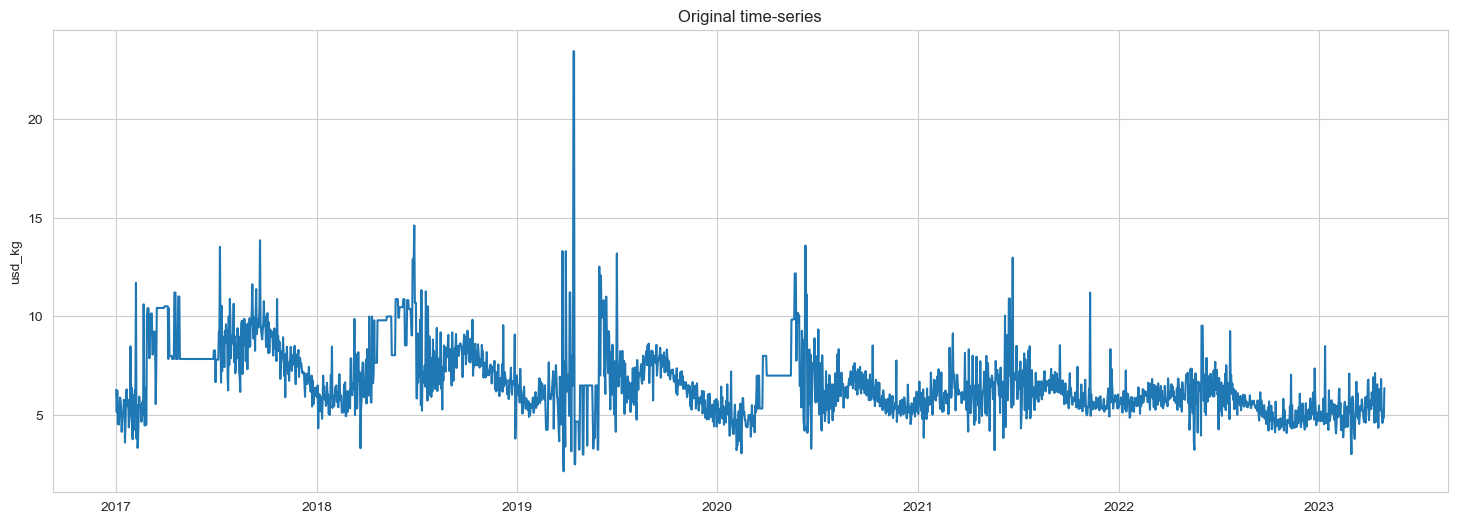

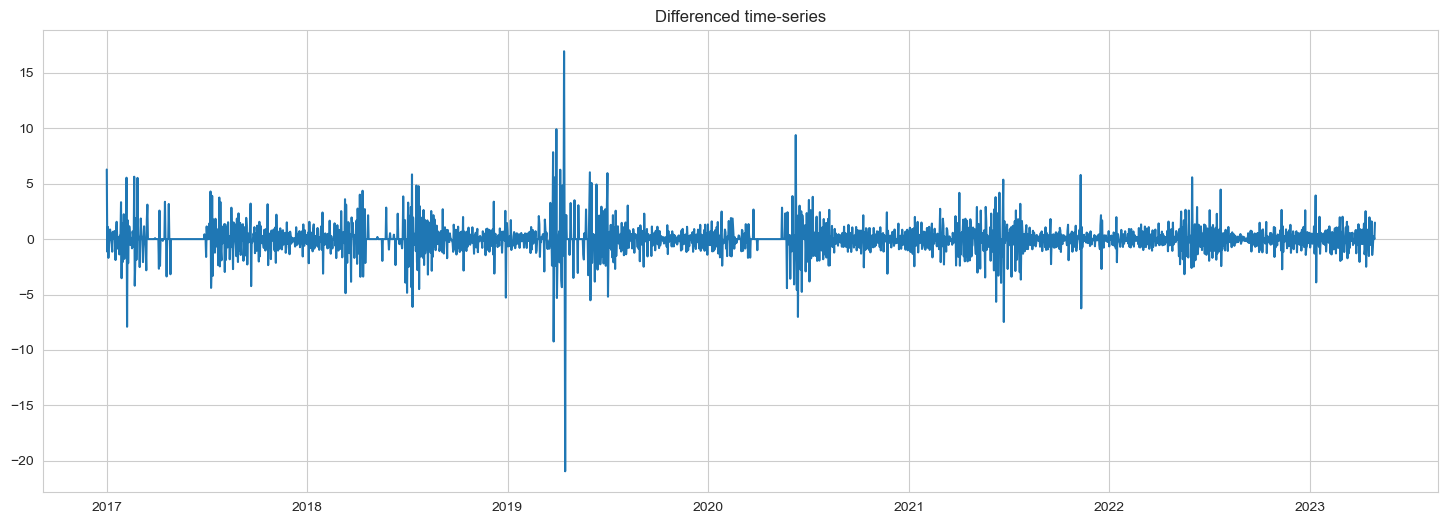

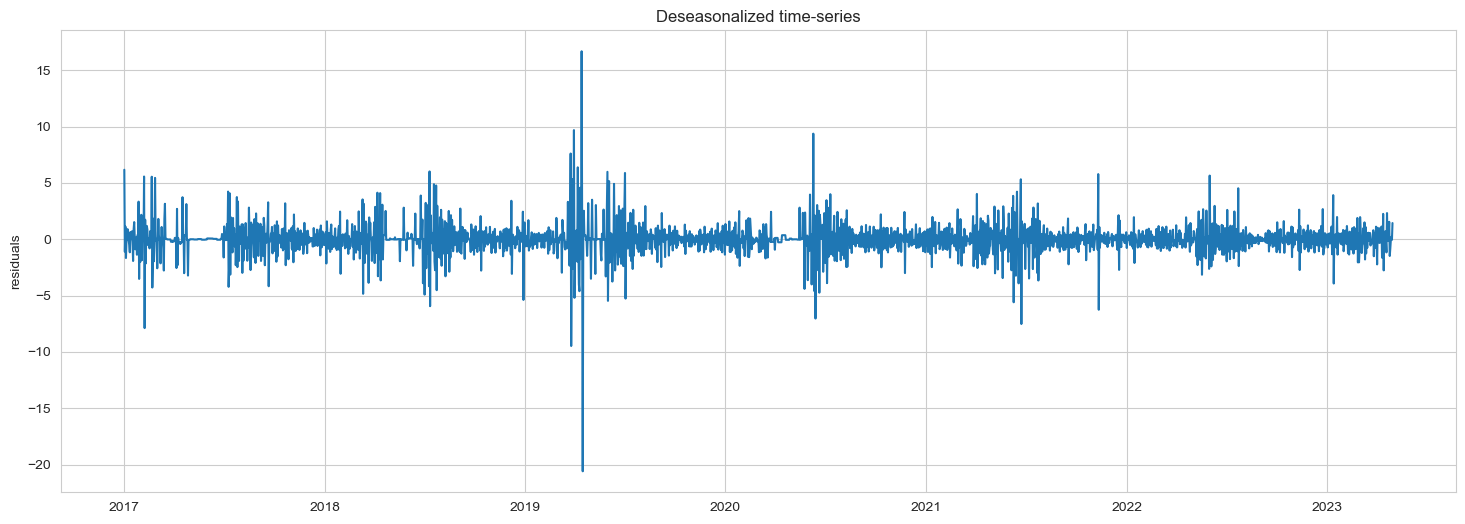

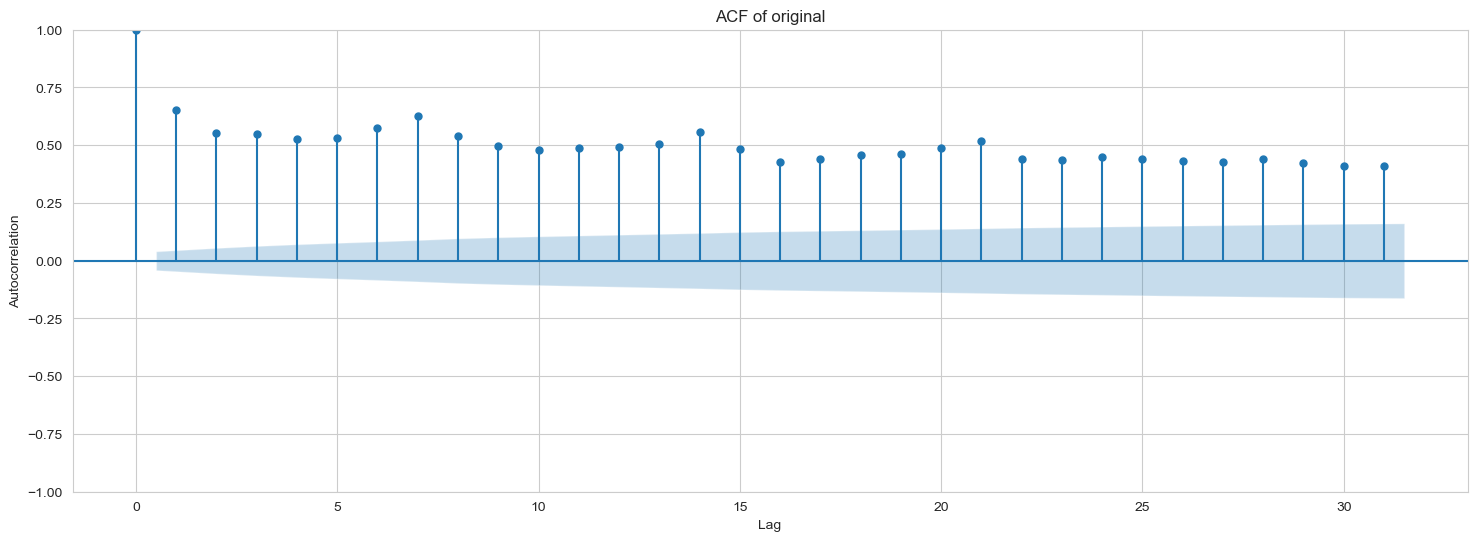

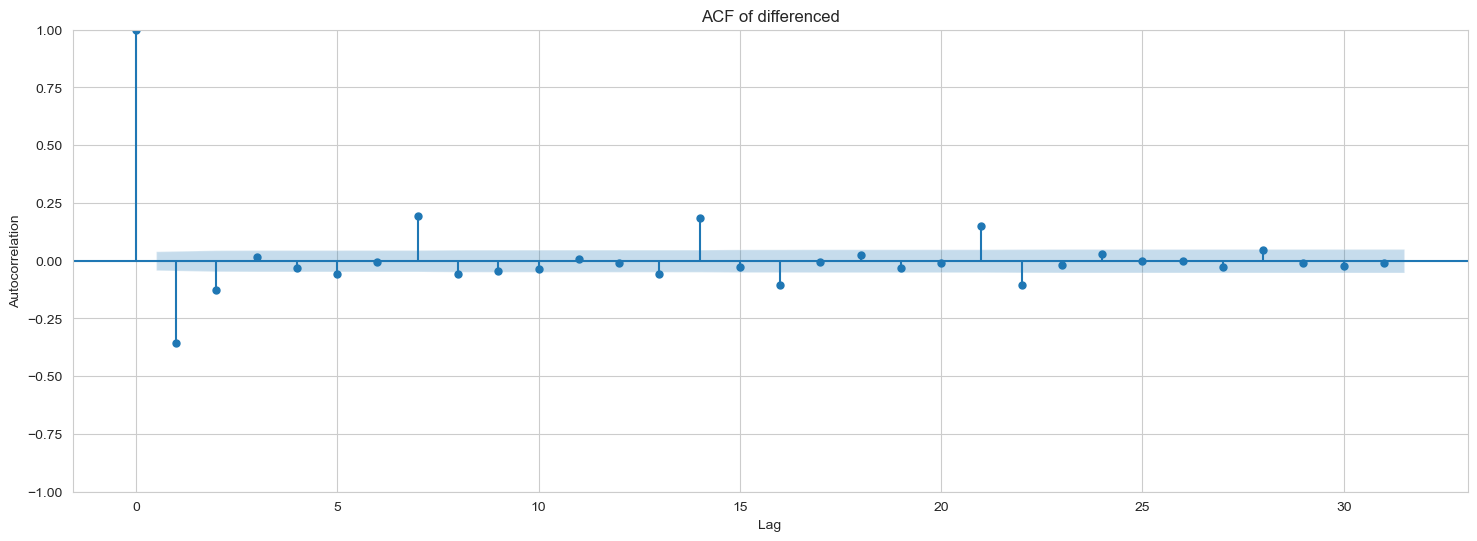

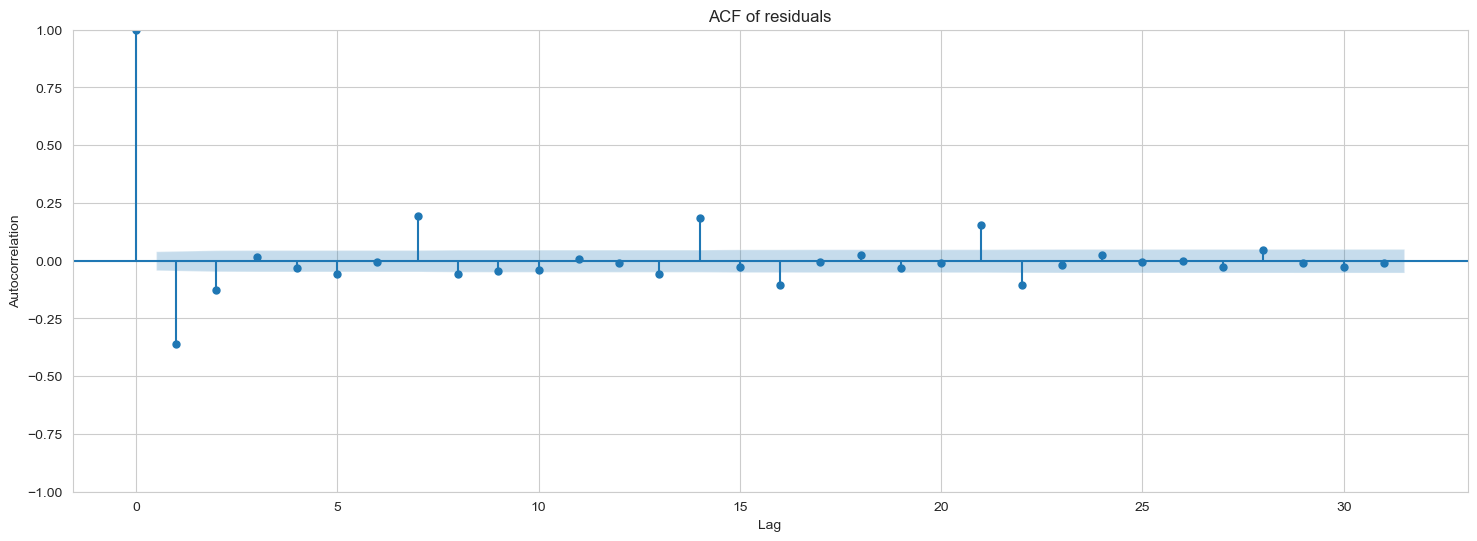

In [337]:
# Plot original
plt.figure(figsize=(18, 6))
sns.lineplot(x=data.index, y=data[observations])
plt.title('Original time-series')
plt.show()

# Plot differenced
plt.figure(figsize=(18, 6))
sns.lineplot(x=data.index, y=np.insert(np.diff(data[observations].values),0,data[observations].values[0]))
plt.title('Differenced time-series')
plt.show()

# Plot residuals
plt.figure(figsize=(18, 6))
sns.lineplot(x=data.index, y=data['residuals'])
plt.title('Deseasonalized time-series')
plt.show()

# Plot ACF with confidence intervals
fig, ax = plt.subplots(figsize=(18, 6))
plot_acf(data[observations], lags=31, alpha=0.05, ax=ax)  # Specify desired number of lags and significance level (alpha)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of original')
plt.show()

# Plot ACF with confidence intervals
fig, ax = plt.subplots(figsize=(18, 6))
plot_acf(np.insert(np.diff(data[observations].values),0,data[observations].values[0]), lags=31, alpha=0.05, ax=ax)  # Specify desired number of lags and significance level (alpha)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of differenced')
plt.show()

# Plot ACF with confidence intervals
fig, ax = plt.subplots(figsize=(18, 6))
plot_acf(data['residuals'], lags=31, alpha=0.05, ax=ax)  # Specify desired number of lags and significance level (alpha)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of residuals')
plt.show()

In [189]:
# # Generate white noise
# # mean = 0
# # std = 1
# # white_noise = np.random.normal(np.mean(data['residuals']), np.std(data['residuals']), size=len(data.index))
# # genesis = residuals.copy()
# from math import sqrt
# from sklearn.metrics import mean_squared_error
#
#
# final_genesis = []
#
# for i in tqdm(range(100)):
#
#     genesis = np.random.normal(0, 1, size=len(data.index))
#
#     # Trough every extraction
#     for iteration_terms in reversed(seasonal_terms):
#
#         # Apply the transformations
#         for granularity in reversed(iteration_terms):
#             terms = iteration_terms[granularity]
#             # Get the labels for that granularity
#             labels = data[granularity].values
#             # Alter every observation
#             for index, observation in enumerate(genesis):
#                 pt = terms[labels[index]]['yeo-johnson']
#                 # genesis[index] =  pt.inverse_transform(np.array(genesis[index]*terms[labels[index]]['std']+terms[labels[index]]['mean']).reshape(-1,1))
#                 genesis[index] = pt.inverse_transform(np.array(genesis[index]).reshape(-1,1))
#
#     # Restore the differencing
#     genesis[0] = data[observations].values[0]
#     genesis = np.cumsum(genesis)
#
#     final_genesis.append(genesis)
#
#     median_rms = sqrt(mean_squared_error(residuals, np.median(final_genesis, axis=0)))
#     print('Median: {}'.format(median_rms))
#     mean_rms = sqrt(mean_squared_error(residuals, np.mean(final_genesis, axis=0)))
#     print('Mean: {}'.format(mean_rms))


In [190]:
# improved_genesis = np.median(final_genesis, axis=0)

In [191]:
# # Plot original
# plt.figure(figsize=(18, 6))
# sns.lineplot(x=data.index, y=data[observations])
# plt.title('Original time-series')
# plt.show()
#
# # Plot genesis
# plt.figure(figsize=(18, 6))
# sns.lineplot(x=data.index, y=improved_genesis)
# plt.title('Reconstructed time-series with residuals/whitenoise')
# plt.show()
#
# # Plot trend
# plt.figure(figsize=(18, 6))
# sns.lineplot(x=data.index, y=data[observations]/improved_genesis)
# plt.title('Reconstructed time-series with residuals/whitenoise')
# plt.show()
#
# # Plot residuals
# plt.figure(figsize=(18, 6))
# sns.lineplot(x=data.index, y=residuals)
# plt.title('Deseasonalized time-series')
# plt.show()
#
# # # Plot white noise
# # plt.figure(figsize=(18, 6))
# # sns.lineplot(x=data.index, y=white_noise)
# # plt.title('White Noise')
# # plt.show()
#
#
# # # Plot ACF with confidence intervals
# # fig, ax = plt.subplots(figsize=(18, 6))
# # plot_acf(data[observations], lags=31, alpha=0.05, ax=ax)  # Specify desired number of lags and significance level (alpha)
# # plt.xlabel('Lag')
# # plt.ylabel('Autocorrelation')
# # plt.title('ACF of Original time-series')
# # plt.show()
# #
# # # Plot ACF with confidence intervals
# # fig, ax = plt.subplots(figsize=(18, 6))
# # plot_acf(residuals, lags=31, alpha=0.05, ax=ax)  # Specify desired number of lags and significance level (alpha)
# # plt.xlabel('Lag')
# # plt.ylabel('Autocorrelation')
# # plt.title('ACF of Deseasonalized time-series')
# # plt.show()
# # #
# # # Plot ACF with confidence intervals
# # fig, ax = plt.subplots(figsize=(18, 6))
# # plot_acf(white_noise, lags=31, alpha=0.05, ax=ax)  # Specify desired number of lags and significance level (alpha)
# # plt.xlabel('Lag')
# # plt.ylabel('Autocorrelation')
# # plt.title('ACF of White Noise')
# # plt.show()

In [192]:
# # Plot the seasonal patterns
# for key, value in seasonal_patterns.items():
#     plt.figure(figsize=(18, 6))
#     sns.lineplot(x=data.index, y=value)
#     plt.title(key)
#     plt.show()

### Extract the trend

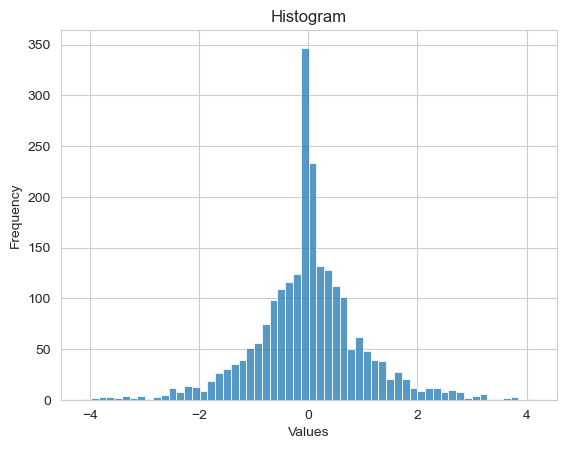

2.107491552442891
-1.0088569241509428e-18
0.9999999999999998


In [267]:
from scipy.stats import kurtosis

# Create histogram using Seaborn
sns.histplot(data['residuals'], kde=False)

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')

# Display the histogram
plt.show()

print(kurtosis(data['residuals']))
print(np.mean(data['residuals']))
print(np.std(data['residuals']))

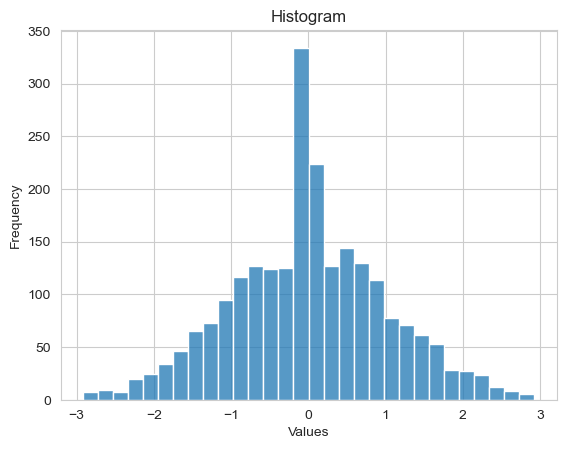

0.02731225557543393
7.878692169559743e-18
0.9999999999999979


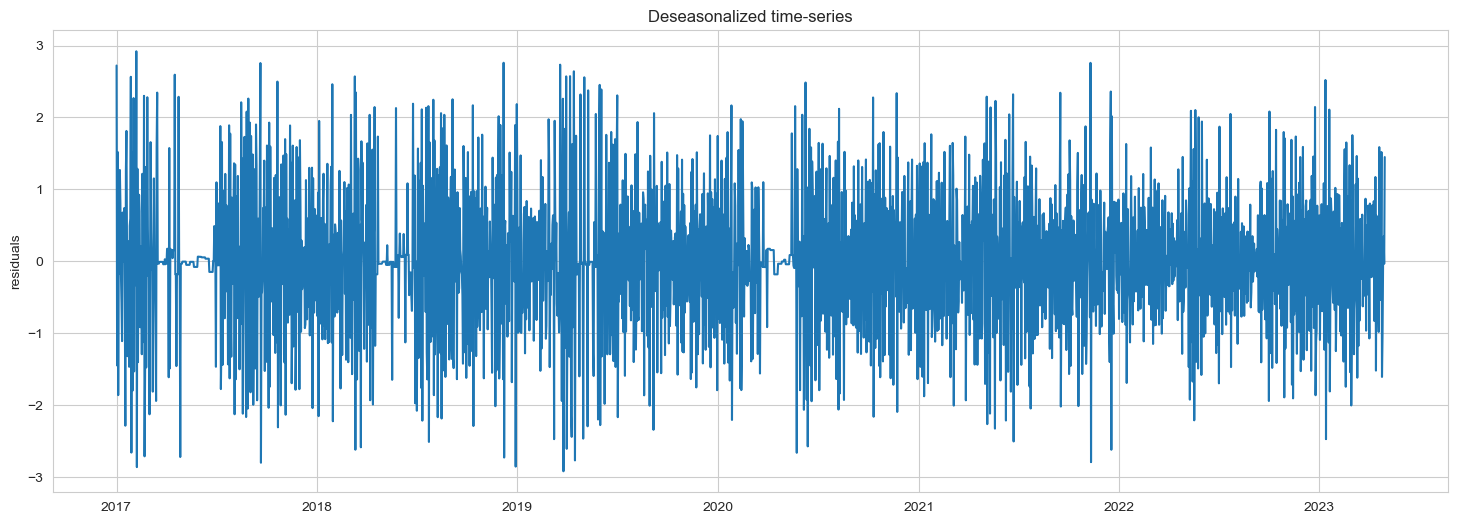

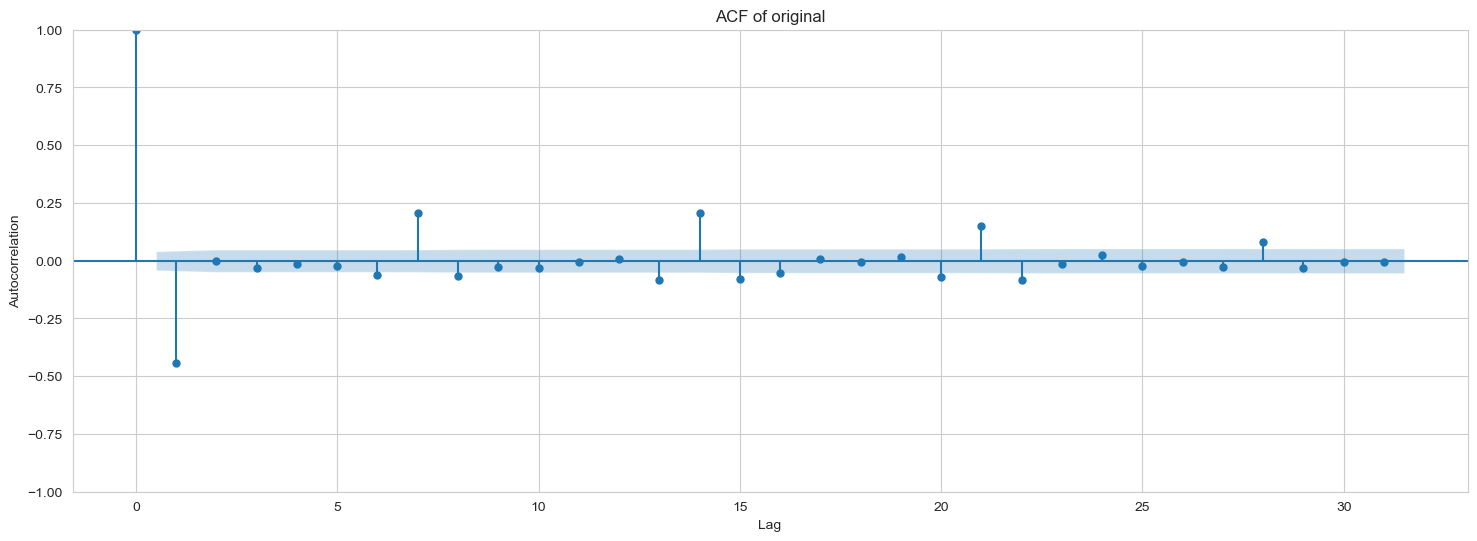

In [331]:
def my_function(observations):

    # Calculate the mean and standard deviation of the original observations
    original_mean = np.mean(observations)
    original_std = np.std(observations)

    # Apply the log transformation to the adjusted observations
    log_transformed = np.sign(observations)*np.log(0.8*np.abs(observations)+1)

    # Calculate the mean and standard deviation of the log-transformed values
    transformed_mean = np.mean(log_transformed)
    transformed_std = np.std(log_transformed)

    # Adjust the mean of the log-transformed values to match the original mean
    log_transformed_adjusted = log_transformed - (transformed_mean - original_mean)

    # Scale the standard deviation of the log-transformed values to match the original standard deviation
    log_transformed_scaled = log_transformed_adjusted * (original_std / transformed_std)

    return log_transformed_scaled, original_mean, original_std, transformed_mean, transformed_std

def convert_back(transformed_values, original_mean, original_std, transformed_mean, transformed_std):

    temp = transformed_values/original_std*transformed_std

    temp = temp + (transformed_mean-original_mean)

    # Apply the inverse log transformation to get the original values
    final = (np.exp(np.abs(temp))-1) / 0.8
    final *= np.sign(temp)

    return temp


iu,original_mean, original_std, transformed_mean, transformed_std = my_function(data['residuals'])

# Create histogram using Seaborn
sns.histplot(iu, kde=False)

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')

# Display the histogram
plt.show()
print(kurtosis(iu))
print(np.mean(iu))
print(np.std(iu))

# Plot residuals
plt.figure(figsize=(18, 6))
sns.lineplot(x=data.index, y=iu)
plt.title('Deseasonalized time-series')
plt.show()

# Plot ACF with confidence intervals
fig, ax = plt.subplots(figsize=(18, 6))
plot_acf(iu, lags=31, alpha=0.05, ax=ax)  # Specify desired number of lags and significance level (alpha)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of original')
plt.show()


In [332]:
# Generate white noise
# mean = 0
# std = 1
# white_noise = np.random.normal(np.mean(data['residuals']), np.std(data['residuals']), size=len(data.index))
# genesis = residuals.copy()
from math import sqrt
from sklearn.metrics import mean_squared_error


final_genesis = []

for i in tqdm(range(50)):

    genesis = np.random.normal(0, 1, size=len(data.index))
    genesis = convert_back(genesis, original_mean, original_std, transformed_mean, transformed_std)

    # Trough every extraction
    for iteration_terms in reversed(seasonal_terms):

        # Apply the transformations
        for granularity in reversed(iteration_terms):
            terms = iteration_terms[granularity]
            # Get the labels for that granularity
            labels = data[granularity].values
            # Alter every observation
            for index, observation in enumerate(genesis):
                pt = terms[labels[index]]['yeo-johnson']
                # genesis[index] =  pt.inverse_transform(np.array(genesis[index]*terms[labels[index]]['std']+terms[labels[index]]['mean']).reshape(-1,1))
                genesis[index] = pt.inverse_transform(np.array(genesis[index]).reshape(-1,1))

    # Restore the differencing
    genesis[0] = data[observations].values[0]
    genesis = np.cumsum(genesis)

    final_genesis.append(genesis)

    median_rms = sqrt(mean_squared_error(residuals, np.median(final_genesis, axis=0)))
    print('Median: {}'.format(median_rms))
    mean_rms = sqrt(mean_squared_error(residuals, np.mean(final_genesis, axis=0)))
    print('Mean: {}'.format(mean_rms))


  0%|          | 0/50 [00:00<?, ?it/s]

Median: 17.28698892407524
Mean: 17.28698892407524
Median: 18.85647766740554
Mean: 18.85647766740554
Median: 14.106355164598156
Mean: 14.969937081762007
Median: 11.622964836156065
Mean: 14.139452786404894
Median: 16.41515286953905
Mean: 16.633777885737672
Median: 13.15328429385569
Mean: 14.79603646496607
Median: 10.556826645490279
Mean: 11.884602810780693
Median: 7.976384292844201
Mean: 9.885782734011231
Median: 9.124107475327667
Mean: 10.225029862066837
Median: 7.155178589948119
Mean: 8.43212423701851
Median: 9.088988609056512
Mean: 9.943043559604405
Median: 10.831862562222476
Mean: 12.929679253518596
Median: 9.080044173336441
Mean: 10.208491118958847
Median: 9.775936244173225
Mean: 11.010244620964002
Median: 11.624219624482029
Mean: 11.725921162568847
Median: 11.551569633981472
Mean: 11.83479783241374
Median: 10.230205469324734
Mean: 10.768904551556467
Median: 11.35045751772445
Mean: 11.636277068643626
Median: 12.273283082996562
Mean: 11.792586042554005
Median: 13.376466337174259
Mean

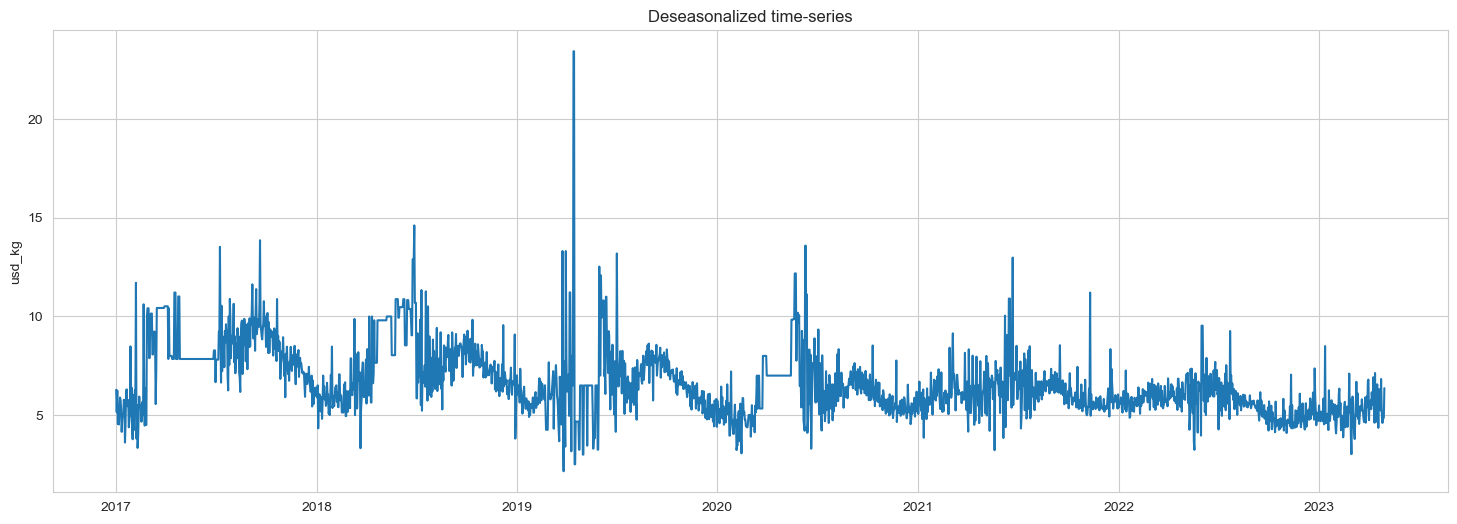

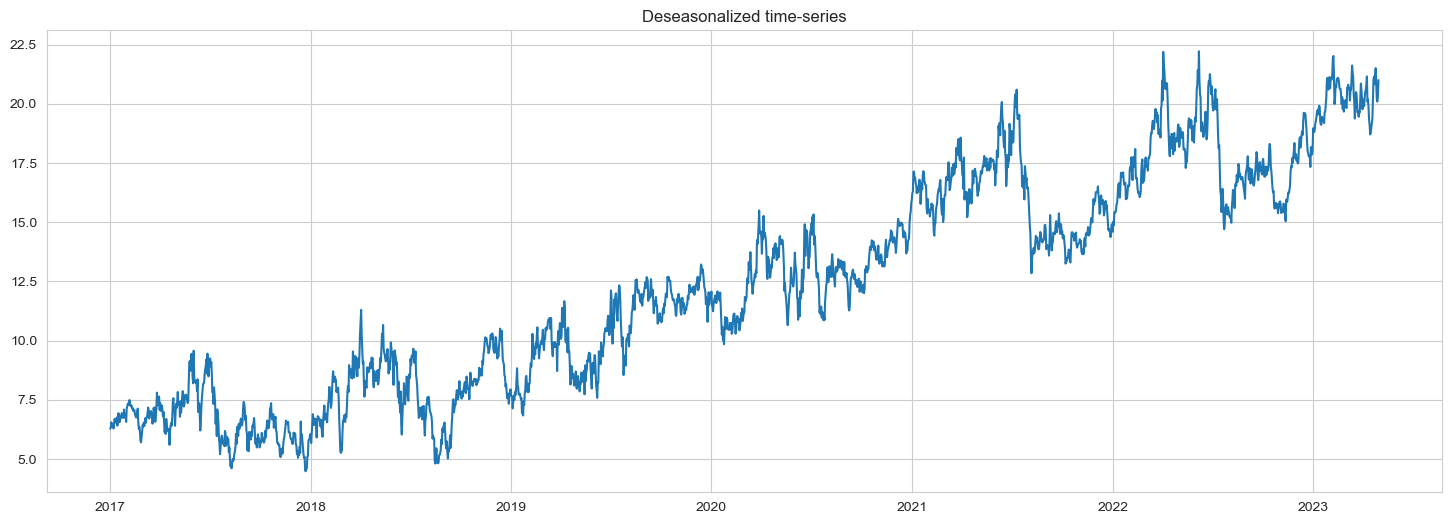

In [334]:
improved_genesis = np.median(final_genesis, axis=0)


# Plot residuals
plt.figure(figsize=(18, 6))
sns.lineplot(x=data.index, y=data[observations])
plt.title('Deseasonalized time-series')
plt.show()

# Plot residuals
plt.figure(figsize=(18, 6))
sns.lineplot(x=data.index, y=improved_genesis)
plt.title('Deseasonalized time-series')
plt.show()

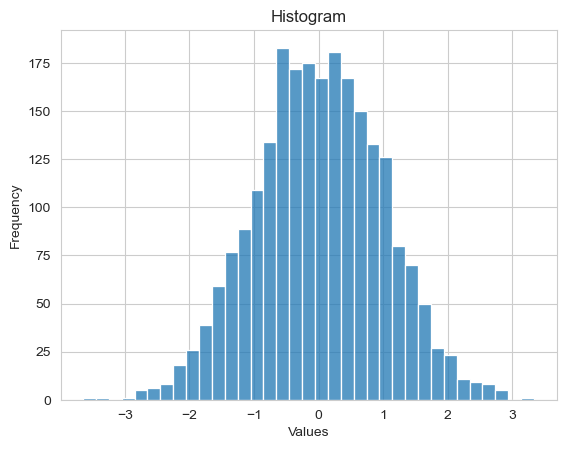

-0.098352727548086
0.010762580137535263
0.9887347454969296


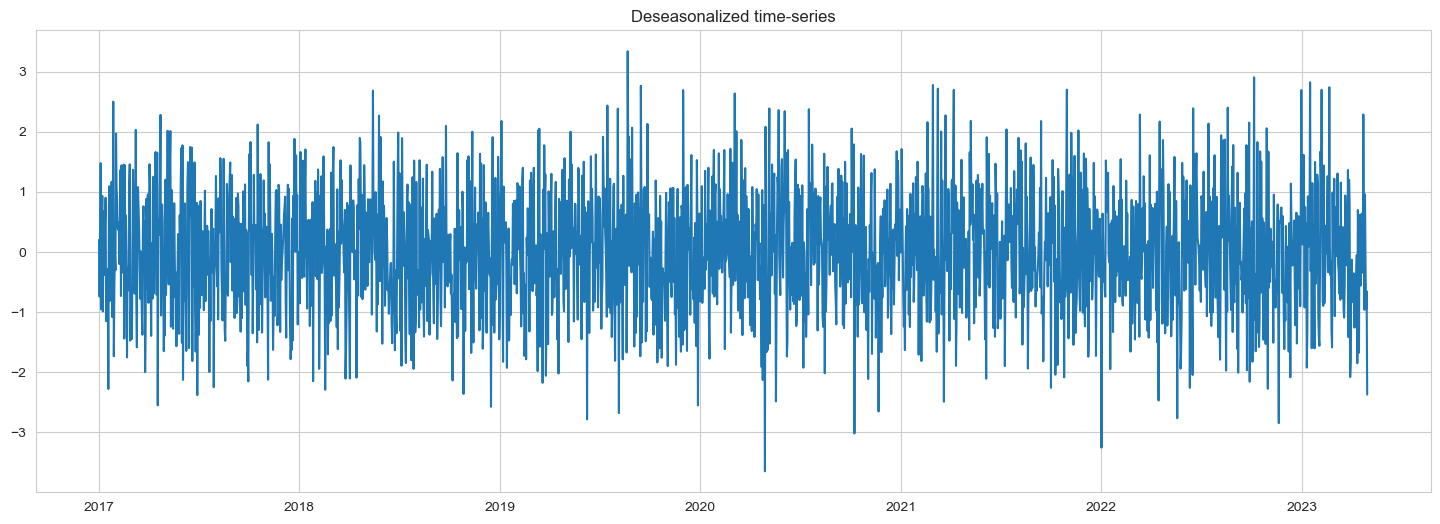

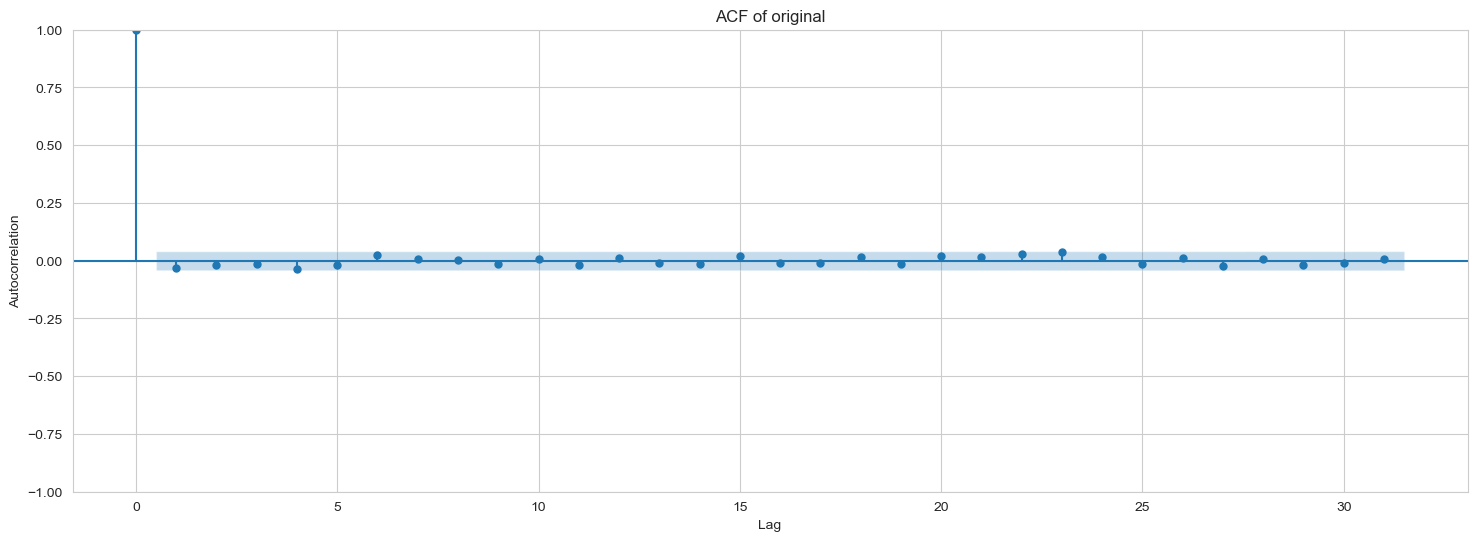

In [319]:
mean = 0
std = 1
white_noise = np.random.normal(mean, std, size=len(data.index))

# Create histogram using Seaborn
sns.histplot(white_noise, kde=False)

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')

# Display the histogram
plt.show()

print(kurtosis(white_noise))
print(np.mean(white_noise))
print(np.std(white_noise))

# Plot residuals
plt.figure(figsize=(18, 6))
sns.lineplot(x=data.index, y=white_noise)
plt.title('Deseasonalized time-series')
plt.show()

# Plot ACF with confidence intervals
fig, ax = plt.subplots(figsize=(18, 6))
plot_acf(white_noise, lags=31, alpha=0.05, ax=ax)  # Specify desired number of lags and significance level (alpha)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of original')
plt.show()


In [92]:
np.std(data['residuals'])

0.9999999999999998

In [83]:
trend = []

for i in tqdm(range(100000)):
    mean = 0
    std = 1
    white_noise = np.random.normal(mean, std, size=len(data.index))

    current_trend = data['residuals']/white_noise
    trend.append(current_trend)

trend = np.mean(trend, axis=0)

  0%|          | 0/100000 [00:00<?, ?it/s]

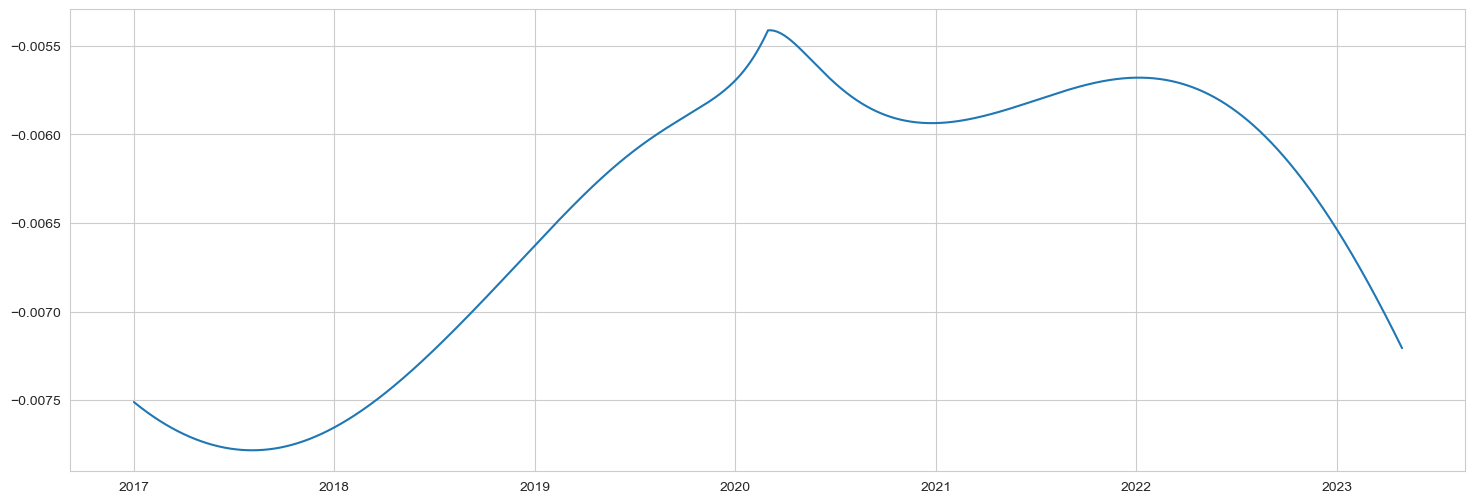

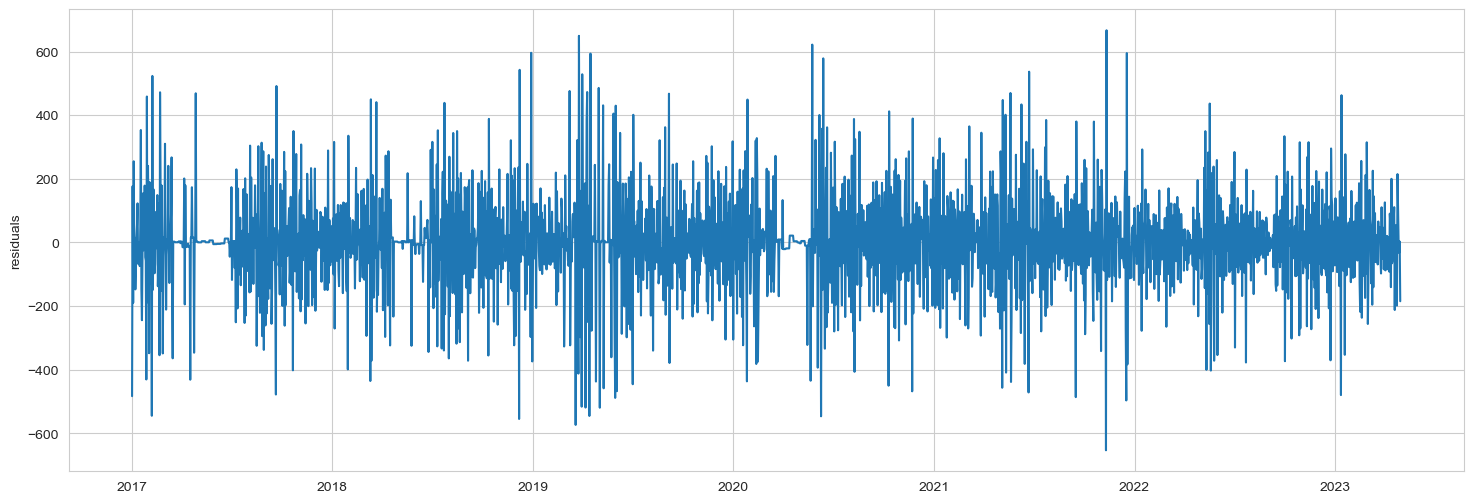

In [91]:
lowess = sm.nonparametric.lowess(data['residuals'], data.index, frac=1)

# Extract the trend component
trend = lowess[:, 1]

# Plot trend
plt.figure(figsize=(18, 6))
sns.lineplot(x=data.index, y=trend)
plt.show()


# Plot residuals
plt.figure(figsize=(18, 6))
sns.lineplot(x=data.index, y=data['residuals']/trend)
plt.show()

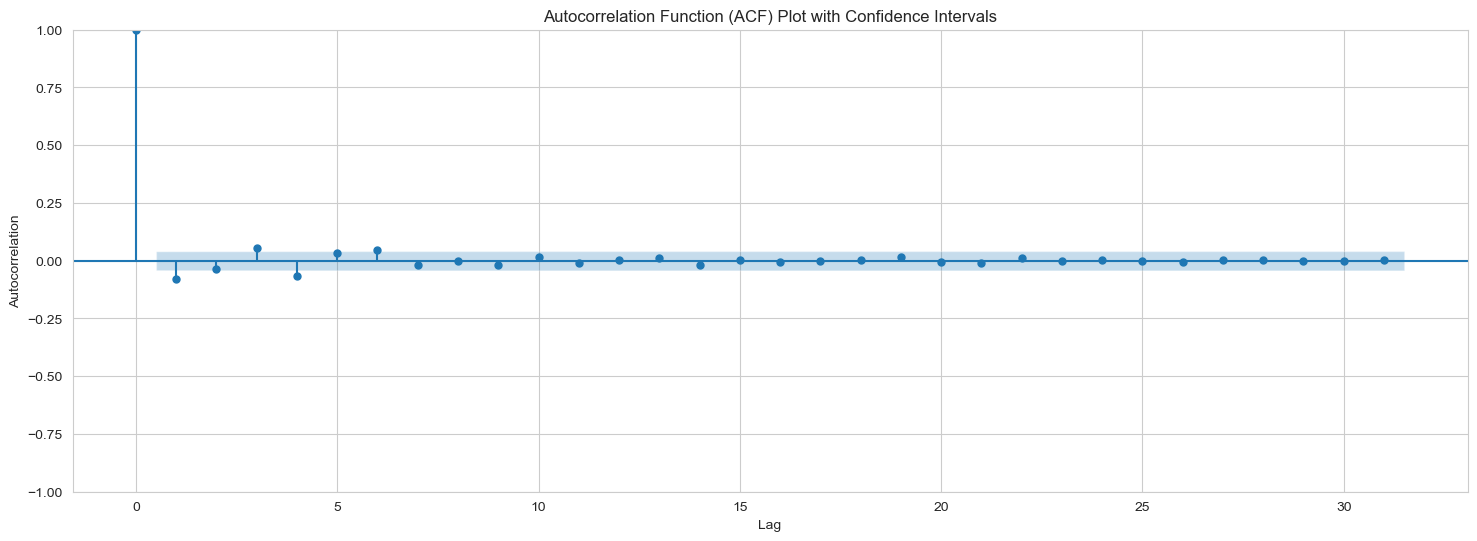

In [88]:
# Plot ACF with confidence intervals
fig, ax = plt.subplots(figsize=(18, 6))
plot_acf(data['residuals']/trend, lags=31, alpha=0.05, ax=ax)  # Specify desired number of lags and significance level (alpha)
plt.xlabel('Lag')

plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot with Confidence Intervals')
plt.show()